In [21]:
from cleanba.environments import BoxobanConfig
from cleanba import cleanba_impala
from learned_planner.interp.utils import jax_to_th, load_jax_model_to_torch
import pathlib
import torch
from learned_planner.interp.utils import load_jax_model_to_torch
from huggingface_hub import snapshot_download
from plotly.subplots import make_subplots
import plotly.graph_objects as go

MODEL_PATH_IN_REPO = "drc33/bkynosqi/cp_2002944000/" # DRC(3, 3) 2B checkpoint
MODEL_BASE_PATH = pathlib.Path(
    snapshot_download("AlignmentResearch/learned-planner", allow_patterns=[MODEL_PATH_IN_REPO + "*"]),
) # only download the specific model
MODEL_PATH = MODEL_BASE_PATH / MODEL_PATH_IN_REPO

BOXOBAN_CACHE = 'boxoban-cache'

env = BoxobanConfig(
    cache_path= BOXOBAN_CACHE,
    num_envs=1,
    max_episode_steps=120,
    asynchronous=False,
    tinyworld_obs=True,
).make()

#jax_policy, carry_t, jax_args, train_state, _ = cleanba_impala.load_train_state(MODEL_PATH, env)
cfg_th, policy_th = load_jax_model_to_torch(MODEL_PATH, env)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 15448.63it/s]
/opt/conda/envs/sokoban/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning:

WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0



fence (128, 1, 3, 3)
fence (128, 1, 3, 3)
fence (128, 1, 3, 3)
fence (128, 1, 3, 3)
fence (128, 1, 3, 3)
fence (128, 1, 3, 3)


In [22]:
from torchinfo import summary

summary(policy_th)

Layer (type:depth-idx)                             Param #
RecurrentFeaturesExtractorActorCriticPolicy        --
├─ConvLSTMFeaturesExtractor: 1-1                   --
│    └─ModuleList: 2-1                             --
│    │    └─ConvLSTMCell: 3-1                      148,800
│    │    └─ConvLSTMCell: 3-2                      148,800
│    │    └─ConvLSTMCell: 3-3                      148,800
│    └─Sequential: 2-2                             --
│    │    └─Conv2d: 3-4                            1,568
│    │    └─Identity: 3-5                          --
│    │    └─Conv2d: 3-6                            16,416
│    │    └─Identity: 3-7                          --
│    └─HookPoint: 2-3                              --
├─ConvLSTMFeaturesExtractor: 1-2                   (recursive)
│    └─ModuleList: 2-4                             (recursive)
│    │    └─ConvLSTMCell: 3-8                      (recursive)
│    │    └─ConvLSTMCell: 3-9                      (recursive)
│    │    └─ConvLST

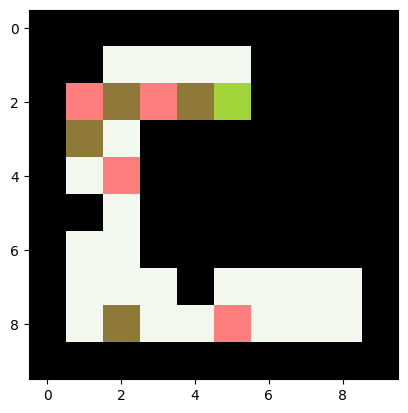

In [23]:
# observation is of shape (1, 3, 10, 10)?
import matplotlib.pyplot as plt
obs, info = env.reset()
import einops
plt.imshow(einops.rearrange(obs[0], "c h w -> h w c"))

In [24]:
# policy_th.mlp_extractor
# policy_th.mlp_extractor.policy_net
# action, value, logprobs, state = policy_th(obs, state, episode_starts)


In [25]:
#init state is a list of three tensors of shape torch.Size([1?, 1?, 32, 10, 10]) full of zeros?
initial_state = policy_th.recurrent_initial_state(1)
action, value, logprobs, state = policy_th(torch.Tensor(obs), initial_state, torch.Tensor([1]).bool())
print(action)
print(value)
print(logprobs)
print(state)


tensor([[2]])
tensor([[5.9910]], grad_fn=<AddmmBackward0>)
tensor([-0.1139], grad_fn=<SumBackward1>)
[(tensor([[[[[-3.0168e-02,  1.7206e-02,  4.2406e-02,  ..., -2.9256e-02,
            -3.5225e-02, -1.2248e-02],
           [ 1.4209e-02, -5.8116e-02,  2.9158e-02,  ..., -2.1116e-02,
            -3.9403e-02, -6.7609e-03],
           [ 7.3824e-04, -7.3581e-02, -4.8825e-02,  ..., -1.7045e-02,
            -5.5633e-02, -8.6492e-03],
           ...,
           [ 1.3193e-01, -9.8110e-03,  2.6338e-01,  ..., -1.0325e-02,
            -4.1301e-02,  1.1888e-03],
           [-1.4386e-01,  1.4979e-02, -4.8741e-02,  ..., -6.1250e-02,
            -3.2851e-02,  2.5349e-02],
           [-4.2358e-02, -6.6948e-02, -9.3210e-03,  ..., -2.2854e-02,
            -5.3155e-02, -9.7590e-02]],

          [[-5.8575e-02,  8.1258e-02,  1.2246e-01,  ..., -1.0220e-03,
             1.5516e-03, -1.0752e-01],
           [-3.7545e-03,  1.2128e-01,  1.1977e-01,  ..., -1.7152e-02,
            -1.9670e-03, -8.8554e-02],
       

In [26]:
obs, info = env.reset()
obs = torch.Tensor(obs)
state = policy_th.recurrent_initial_state(1)
episode_starts = torch.Tensor([1]).bool()
action, value, logprobs, state = policy_th(obs, state, episode_starts)

In [27]:
def show_obs(obs):
    obs = einops.rearrange(obs.squeeze(), 'c h w -> h w c')
    plt.imshow(obs)
    plt.show()


obs, info = env.reset()
obs = torch.Tensor(obs)
state = policy_th.recurrent_initial_state(1)
episode_starts = torch.Tensor([1]).bool()

In [50]:
def play_sokoban(env, policy_th, num_steps=100):
    obs, info = env.reset()
    obs = torch.Tensor(obs)
    state = policy_th.recurrent_initial_state(1)
    episode_starts = torch.Tensor([1]).bool()

    frames = []
    values = []
    actions = []

    for step in range(num_steps):
        with torch.no_grad():
            action, value, logprobs, next_state = policy_th(obs, state, episode_starts, deterministic=True)
        
        action_int = action.item()
        obs, reward, done, truncated, info = env.step([action_int])
        
        obs = torch.Tensor(obs)
        state = next_state
        episode_starts = torch.Tensor([0]).bool()
        
        frames.append(obs.squeeze().permute(1, 2, 0).numpy())
        values.append(value.item())
        actions.append(action_int)
        
        if done or truncated:
            break

    return frames, values, actions, info

def plot_sokoban_game(frames, values, actions):
    fig = make_subplots(rows=1, cols=2, column_widths=[0.7, 0.3], 
                        specs=[[{"type": "image"}, {"type": "scatter"}]])

    fig.add_trace(go.Image(z=frames[0]), row=1, col=1)
    fig.add_trace(go.Scatter(x=[0], y=[values[0]], mode='lines+markers'), row=1, col=2)

    # Calculate initial y-axis range
    y_min, y_max = min(values), max(values)
    y_range = y_max - y_min
    y_min -= 0.1 * y_range  # Add 10% padding
    y_max += 0.1 * y_range

    fig.update_layout(
        title="Sokoban Agent Play",
        xaxis2=dict(title="Step"),
        yaxis2=dict(title="Value", range=[y_min, y_max]),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="⏮", method="animate", args=[["previous"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}]),
                    dict(label="⏭", method="animate", args=[["next"], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}]),
                    dict(label="▶", method="animate", args=[None, {"frame": {"duration": 200, "redraw": True}, "fromcurrent": True, "transition": {"duration": 0}}]),
                    dict(label="⏸", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}])
                ],
                direction="left",
                pad={"r": 10, "t": 10},
                showactive=False,
                x=0.1,
                xanchor="right",
                y=1.1,
                yanchor="top"
            )
        ],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Step: ",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 0},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [
                {
                    "args": [
                        [i],
                        {"frame": {"duration": 0, "redraw": True},
                         "mode": "immediate",
                         "transition": {"duration": 0}}
                    ],
                    "label": str(i),
                    "method": "animate"
                } for i in range(len(frames))
            ]
        }]
    )

    fig_frames = []
    for i in range(len(frames)):
        # Update y-axis range if necessary
        current_values = values[:i+1]
        y_min = min(min(current_values), y_min)
        y_max = max(max(current_values), y_max)
        y_range = y_max - y_min
        y_min -= 0.1 * y_range  # Add 10% padding
        y_max += 0.1 * y_range

        frame = go.Frame(
            data=[
                go.Image(z=frames[i]),
                go.Scatter(x=list(range(i+1)), y=current_values, mode='lines+markers')
            ],
            layout=go.Layout(
                title_text=f"Step {i+1}, Action: {actions[i]}",
                yaxis2=dict(range=[y_min, y_max])
            ),
            name=str(i)
        )
        fig_frames.append(frame)

    fig.frames = fig_frames
    return fig

frames, values, actions, info = play_sokoban(env, policy_th)
# fig = plot_sokoban_game(frames, values, actions)
# fig.show()

In [53]:
frames_list = []
values_list = []
actions_list = []
level_file_idx_list = []
level_idx_list = []

for i in range(1000):
    if i % 10 == 0:
        print(f"Playing game {i}")
    frames, values, actions, info = play_sokoban(env, policy_th)
    frames_list.append(frames)
    values_list.append(values)
    actions_list.append(actions)
    if 'level_file_idx' in info:
        level_file_idx_list.append(info['level_file_idx'])
        level_idx_list.append(info['level_idx'])
    else:
        level_file_idx_list.append(None)
        level_idx_list.append(None)



Playing game 0
Playing game 10
Playing game 20
Playing game 30
Playing game 40
Playing game 50
Playing game 60
Playing game 70
Playing game 80
Playing game 90
Playing game 100
Playing game 110
Playing game 120
Playing game 130
Playing game 140
Playing game 150
Playing game 160
Playing game 170
Playing game 180
Playing game 190
Playing game 200
Playing game 210
Playing game 220
Playing game 230
Playing game 240
Playing game 250
Playing game 260
Playing game 270
Playing game 280
Playing game 290
Playing game 300
Playing game 310
Playing game 320
Playing game 330
Playing game 340
Playing game 350
Playing game 360
Playing game 370
Playing game 380
Playing game 390
Playing game 400
Playing game 410
Playing game 420
Playing game 430
Playing game 440
Playing game 450
Playing game 460
Playing game 470
Playing game 480
Playing game 490
Playing game 500
Playing game 510
Playing game 520
Playing game 530
Playing game 540
Playing game 550
Playing game 560
Playing game 570
Playing game 580
Playing 

In [68]:
len(set([(x[0], y[0]) if x else None for x, y in zip(level_idx_list, level_file_idx_list)]))


996

In [69]:
import pickle


# Combine all lists into a single object (e.g., a dictionary)
data_to_pickle = {
    'frames_list': frames_list,
    'values_list': values_list,
    'actions_list': actions_list,
    'level_file_idx_list': level_file_idx_list,
    'level_idx_list': level_idx_list
}

# Pickle the data to a single file
with open('lists_data.pkl', 'wb') as f:
    pickle.dump(data_to_pickle, f)

print("Data pickled successfully!")


Data pickled successfully!


In [30]:

# # Hook function: it takes the module, input, and output of the layer
# def hook_fn(module, input, output):
#     print("Hook attached to layer:", module)
#     print("Input to the layer:", input)
#     print("Output from the layer:", output)

# # Assume policy_th is your instantiated policy object
# # Register the hook on the feature extractor
# policy_th.features_extractor.register_forward_hook(hook_fn)

# # To test, pass some input through the policy
# observations = torch.randn(1, *policy_th.observation_space.shape)  # Simulated input
# actions, values, log_probs, state = policy_th(observations, state, episode_starts)


In [31]:
obs, info = env.reset(seed=8)

In [32]:
policy_th

RecurrentFeaturesExtractorActorCriticPolicy(
  (features_extractor): ConvLSTMFeaturesExtractor(
    (cell_list): ModuleList(
      (0-2): 3 x ConvLSTMCell(
        (conv_ih): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (hook_conv_ih): InputDependentHookPoint()
        (conv_hh): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (hook_conv_hh): InputDependentHookPoint()
        (fence_conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid, bias=False)
        (hook_fence_conv): InputDependentHookPoint()
        (hook_pool_project): InputDependentHookPoint()
        (hook_h): InputDependentHookPoint()
        (hook_c): InputDependentHookPoint()
        (hook_layer_input): InputDependentHookPoint()
        (hook_prev_layer_hidden): InputDependentHookPoint()
      )
    )
    (pre_model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=same)
      (1): Identity()
      (2): Conv2